In [2]:
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()
print('0 ---------------------------------------------------------------------------------------')
#---------------------------------------------------------------------------------------
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("RGB")
        img1 = img1.convert("RGB")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

print('1 ---------------------------------------------------------------------------------------')
# Load the training dataset
folder_dataset = datasets.ImageFolder(root="./lfw_funneled/")
print('2 ---------------------------------------------------------------------------------------')
# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])
print('3 ---------------------------------------------------------------------------------------')
# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)
print('4 ---------------------------------------------------------------------------------------')
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        #num_workers=2,
                        batch_size=8)

print('5 ---------------------------------------------------------------------------------------')
# Extract one batch
#example_batch = next(iter(vis_dataloader))
#print(example_batch)
# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
print('6 ---------------------------------------------------------------------------------------')
#concatenated = torch.cat((example_batch[0], example_batch[1]),0)

#imshow(torchvision.utils.make_grid(concatenated))
#print(example_batch[2].numpy().reshape(-1))

# create siameseNetwork
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2
    
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        #num_workers=8,
                        batch_size=64)

net = SiameseNetwork()#.cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

counter = []
loss_history = [] 
iteration_number= 0

# Iterate throught the epochs
for epoch in range(20):
    #print('9 -----------------')
    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):
        #print('10 -----------------')
        
        # Send the images and labels to CUDA
        #img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        #print('11 -----------------')
        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

0 ---------------------------------------------------------------------------------------
1 ---------------------------------------------------------------------------------------
2 ---------------------------------------------------------------------------------------
3 ---------------------------------------------------------------------------------------
4 ---------------------------------------------------------------------------------------
5 ---------------------------------------------------------------------------------------
6 ---------------------------------------------------------------------------------------
Epoch number 0
 Current loss 1.9341158866882324

Epoch number 0
 Current loss 1.0497773885726929



KeyboardInterrupt: 

In [ ]:
#model_scripted = torch.jit.script(net) # Export to TorchScript
#model_scripted.save('model_scripted.pt') # Save

In [ ]:
#model = torch.jit.load('model_scripted.pt')
#model.eval()

In [2]:
#(img1, img2, three) = siamese_dataset.__getitem__(3)
#print(type(three)) # torch.Tensor
#print(three) # [1.] [0.]



In [ ]:
torch.save(net.state_dict(), 'my_model_save.pt')

In [3]:
model = SiameseNetwork()
model.load_state_dict(torch.load('my_model_save.pt'))
model.eval()

SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=384, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)

tensor(1.0027, grad_fn=<AddBackward0>)


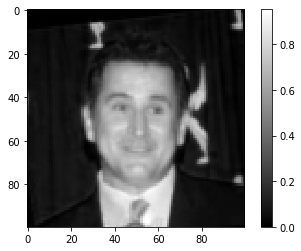

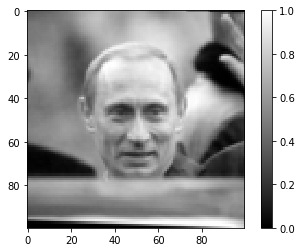

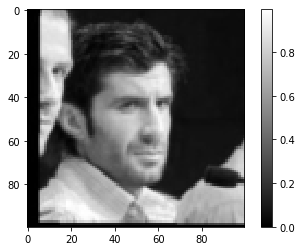

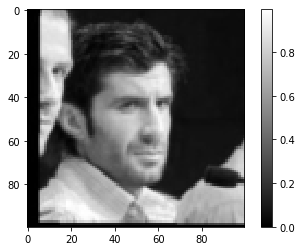

tensor([[-1.9381, -1.5921],
        [-1.9494, -1.5388],
        [-2.3927, -1.8812],
        [-2.6826, -1.4231]], grad_fn=<SliceBackward0>)
tensor([[-2.9043, -1.8552],
        [-1.9494, -1.5388],
        [-2.3927, -1.8812],
        [-2.5007, -1.5522]], grad_fn=<SliceBackward0>)
tensor(3.7467, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<AddBackward0>)


In [4]:

for i, (img0, img1, label) in enumerate(train_dataloader, 0):
    output1, output2 = net(img0, img1)
    #euclidean_distance = F.pairwise_distance(output1, output2)

    #happy_array = np.random.randn(3, 3)
    #print(type(happy_array)) numpy.ndarray
    #print(happy_array) [[1,2,3],[4,5,6],[7,8,9]]
    #print(type(img0)) torch.Tensor
    #print(img0.size()) [64, 1, 100, 100]
    
    point1 = np.array((output1[0][0], output1[0][1]))
    point2 = np.array((output2[0][0], output2[0][1]))

    # finding sum of squares
    sum_sq = np.sum(np.square(point1 - point2))

    # Doing squareroot and
    # printing Euclidean distance
    print(sum_sq)
    
    hundred_times_hundred = img0[0][0]
    im = plt.imshow(hundred_times_hundred, cmap='gray', interpolation='none')
    cbar = plt.colorbar(im)
    plt.show()
    
    hundred_times_hundred = img1[0][0]
    im = plt.imshow(hundred_times_hundred, cmap='gray', interpolation='none')
    cbar = plt.colorbar(im)
    plt.show()
    
    hundred_times_hundred = img0[1][0]
    im = plt.imshow(hundred_times_hundred, cmap='gray', interpolation='none')
    cbar = plt.colorbar(im)
    plt.show()
    
    hundred_times_hundred = img1[1][0]
    im = plt.imshow(hundred_times_hundred, cmap='gray', interpolation='none')
    cbar = plt.colorbar(im)
    plt.show()
    #print(euclidean_distance.size()) [64]
    #print(output1.size()) [64, 2]
    #print(euclidean_distance.item())
    #print(euclidean_distance[:4])
    print(output1[:4])
    print(output2[:4])
    #print(torch.sum(euclidean_distance).item())
    
    
    
    
    output1, output2 = model(img0, img1)
    #euclidean_distance = F.pairwise_distance(output1, output2)
    #print(torch.sum(euclidean_distance).item())
    
    point1 = np.array((output1[0][0], output1[0][1]))
    point2 = np.array((output2[0][0], output2[0][1]))

    # finding sum of squares
    sum_sq = np.sum(np.square(point1 - point2))

    # Doing squareroot and
    # printing Euclidean distance
    print(sum_sq)
    
    #------------------ second pair
    #euclidean_distance = F.pairwise_distance(output1, output2)
    #print(torch.sum(euclidean_distance).item())
    
    point1 = np.array((output1[1][0], output1[1][1]))
    point2 = np.array((output2[1][0], output2[1][1]))

    # finding sum of squares
    sum_sq = np.sum(np.square(point1 - point2))

    # Doing squareroot and
    # printing Euclidean distance
    print(sum_sq)
    
    break